In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
df=pd.read_csv("NYC_obgyn_final.csv", header=None)
df.columns=["Malpractice","Boro","Education","Name","Specialty"]
df.loc[254,]

Malpractice                                        None reported
Boro                                                       Bronx
Education      NY COLLEGE OF OSTEOPATHIC MEDICINE, INSTITUTE ...
Name                                             BERNAL, ARMANDO
Specialty                              Obstetrics and Gynecology
Name: 254, dtype: object

In [3]:
def split_out_year(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    school=ed[0:s[0]]
    year= ed[s[1]:]
    return year
def split_out_school(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    return ed[0:s[0]]
df['School']=list(map(split_out_school,df.Education))
df['Year']=list(map(split_out_year,df.Education))
df=df.drop("Education",axis=1)
# df=df.drop_duplicates("Name")
# df

In [4]:
us_states=pd.read_csv("States.csv")
us_states=us_states[us_states.x!='US']
us_states=us_states['x']

In [5]:
df['State'] = df['School'].str.extract('( [A-Z]{2}$)')
df.State=df.State.str.strip()

In [6]:
# Finding country where they went to school
ind=-1
countries=[]
for st in df.State:
    ind+=1
    if st in us_states.values:
        countries.append('USA')
    else:
        try:
            country=re.search(', [A-Z]+$',df.School[ind]).group() #{1}[a-z]
            #print(country[2:])
            countries.append(country[2:])#df['School'].str.extract(', [A-Z]{1}[a-z]+$')
        except Exception as e:
            #print(e)
            countries.append('')
            continue
df['Country']=countries

In [7]:
## TO DO ### Fix New York - NY
#df[df['Country']==''].School

In [8]:
def find_num_pay(mal):
    # check Judgments and Arbitration Awards
    start,end =re.search('Number of awards:',mal).span()
    try:
        a= int(mal[end+1:end+2])
    except:
        # check Settlements
        start,end_p =re.search('Number of payments:',mal).span()
        a= int(mal[end_p+1:end_p+2])
    return a

In [9]:
df.loc[254,]

Malpractice                                        None reported
Boro                                                       Bronx
Name                                             BERNAL, ARMANDO
Specialty                              Obstetrics and Gynecology
School         NY COLLEGE OF OSTEOPATHIC MEDICINE, INSTITUTE ...
Year                                                        2008
State                                                         NY
Country                                                      USA
Name: 254, dtype: object

In [10]:
ind=0
num_payments=[]
for m in range(len(df)):
    #print(ind)
    if df.Malpractice[ind]=='None reported':
        num_payments.append(0)
    else:
        a=find_num_pay(df.Malpractice[ind])
        num_payments.append(a)
    ind+=1
df['Num_Payments']=num_payments

In [11]:
# test=pd.DataFrame([df.loc[8]],columns=df.columns)
# test.date='01-09-1998'
# df.loc[8,]

In [12]:
# df_try=df.loc[11]
# df.append([df_try]*5,ignore_index=True)

#create empty columns
df['ind_law_suit']=df['Num_Payments']
df['year']=df['Num_Payments']
df['date']=df['Num_Payments']
df['area']=df['Num_Payments']
df['significance']=df['Num_Payments']

In [13]:
sum(df.Num_Payments)

449

In [14]:
def extract_law_suit_info(deets,ind):
    tmp_mal_rows=pd.DataFrame(columns=df.columns)
    for d in range(1,len(deets)):
        suit_info={}
        suit_info['ind_law_suit']=d
        date=re.search('(..-..-....)', deets[d])
        suit_info['date'] = date.group()
        suit_info['year']=date.group()[6:]
        # area might be zip code or County, State
        try:
            area=re.search('\d{5}',deets[d].strip())
            suit_info['area'] = area.group()
            suit_info['significance']= deets[d].strip()[area.span()[1]+1:]
        except:
            try:
                _,end=date.span()
                area_obj=re.search('[A-Za-z]* *[\w]*(, NY)',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
            except:
                _,end=date.span()
                area_obj=re.search('Not Available',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
        tmp_row=pd.DataFrame([df.loc[ind]],columns=df.columns)
        tmp_row['date']=suit_info['date']
        tmp_row['year']=suit_info['year']
        tmp_row['area']=suit_info['area']
        tmp_row['significance']=suit_info['significance']
        tmp_row['ind_law_suit']=suit_info['ind_law_suit']
        tmp_mal_rows=pd.concat([tmp_mal_rows, tmp_row], axis=0)
    return tmp_mal_rows

In [15]:
# Fill in Law Suit info!
# creates empty data frame to fill
mal_rows=pd.DataFrame(columns=df.columns)
for ind in range(len(df)):
    #print(ind)
    mal=df.Malpractice[ind]
    if mal=='None reported':
        continue
    start,end =re.search('High   |   Low\n',mal).span()
    start2,end2=re.search("\n\nThe doctor\'s malpractice history",mal).span()
    deets=mal[end:start2].strip()
    deets=deets.split('\n')
    if re.search('None reported',deets[1]) != None:
        x,y=re.search('\n(..-..-....)',mal).span()
        x2,y2=re.search('\n\nSettlements',mal).span()
        deets=[0,mal[x+1:x2]]
    tmp_mal_rows=extract_law_suit_info(deets,ind)
    mal_rows=pd.concat([mal_rows, tmp_mal_rows], axis=0)
bueno_rows=df[df.Malpractice=="None reported"]
new_df=pd.concat([bueno_rows,mal_rows],axis=0)

In [16]:
date_rows=mal_rows.set_index('date')

In [17]:
date_rows.year=list(map(lambda x: int(x),date_rows.year))
date_rows

,Malpractice,Boro,Name,Specialty,School,Year,State,Country,Num_Payments,ind_law_suit,year,area,significance
date,,,,,,,,,,,,,
01-11-2017,Malpractice\nLast Updated 03-13-2017\nTO TOP\n...,Brooklyn,"AHMADI, RAMIN",Obstetrics and Gynecology,"SUNY, DWNSTATE M C COLL MED, BROOKLYN NY",1988,NY,USA,3,1,2017,11201,Average
03-16-2015,Malpractice\nLast Updated 03-13-2017\nTO TOP\n...,Brooklyn,"AHMADI, RAMIN",Obstetrics and Gynecology,"SUNY, DWNSTATE M C COLL MED, BROOKLYN NY",1988,NY,USA,3,2,2015,"Kings County, NY",Average
09-07-2012,Malpractice\nLast Updated 03-13-2017\nTO TOP\n...,Brooklyn,"AHMADI, RAMIN",Obstetrics and Gynecology,"SUNY, DWNSTATE M C COLL MED, BROOKLYN NY",1988,NY,USA,3,3,2012,11209,Average
12-18-2012,Malpractice\nLast Updated 02-07-2013\nTO TOP\n...,Brooklyn,"AJAH, MARCEL",Obstetrics and Gynecology,"UNIVERSITY OF MO, COLUMBIA SCHOOL OF MEDICINE,...",1993,MO,USA,3,1,2012,"Queens County, NY",Above Average
02-03-2011,Malpractice\nLast Updated 02-07-2013\nTO TOP\n...,Brooklyn,"AJAH, MARCEL",Obstetrics and Gynecology,"UNIVERSITY OF MO, COLUMBIA SCHOOL OF MEDICINE,...",1993,MO,USA,3,2,2011,"Queens County, NY",Average
05-17-2010,Malpractice\nLast Updated 02-07-2013\nTO TOP\n...,Brooklyn,"AJAH, MARCEL",Obstetrics and Gynecology,"UNIVERSITY OF MO, COLUMBIA SCHOOL OF MEDICINE,...",1993,MO,USA,3,3,2010,"Queens County, NY",Average
05-24-2016,Malpractice\nLast Updated 07-28-2016\nTO TOP\n...,Brooklyn,"ALDAIA, BASSAM",Obstetrics and Gynecology,"UNIVERSITY OF DAMASCUS, FAC OF MEDICINE, DAMAS...",1972,NaN,SYRIA,1,1,2016,"Kings County, NY",Below Average
05-15-2009,Malpractice\nLast Updated 06-09-2009\nTO TOP\n...,Brooklyn,"AMO, GREGORY",Obstetrics and Gynecology,"UNIVERSITY OF GHANA, MEDICAL SCHOOL, ACCRA, GHANA",1976,NaN,GHANA,4,1,2009,"Kings County, NY",Below Average
03-24-2009,Malpractice\nLast Updated 06-09-2009\nTO TOP\n...,Brooklyn,"AMO, GREGORY",Obstetrics and Gynecology,"UNIVERSITY OF GHANA, MEDICAL SCHOOL, ACCRA, GHANA",1976,NaN,GHANA,4,2,2009,"Kings County, NY",Average


In [18]:
# list(map(lambda x:pd.Timestamp(x),mal_rows.date)) #pd.Timestamp()

In [19]:
%matplotlib inline

In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [22]:
import wordcloud
wordcloud = WordCloud().generate(df.School)
# Generate plot

ModuleNotFoundError: No module named 'wordcloud'

(array([28., 50., 51., 38., 54., 62., 44., 43., 61., 31.]),
 array([2008. , 2008.9, 2009.8, 2010.7, 2011.6, 2012.5, 2013.4, 2014.3,
        2015.2, 2016.1, 2017. ]),
 <a list of 10 Patch objects>)

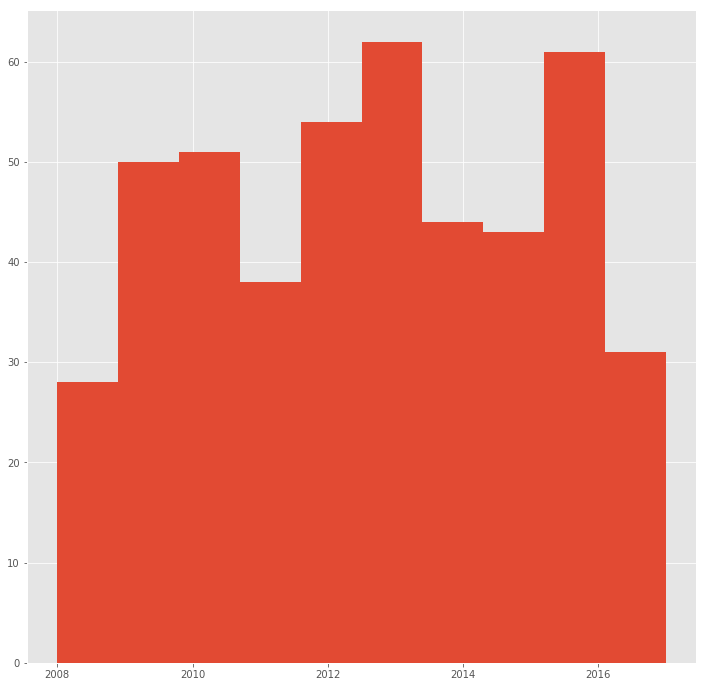

In [101]:
plt.rcParams['figure.figsize']=12,12  # change plot size
plt.hist(date_rows['year'])

In [102]:
import seaborn as sns

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


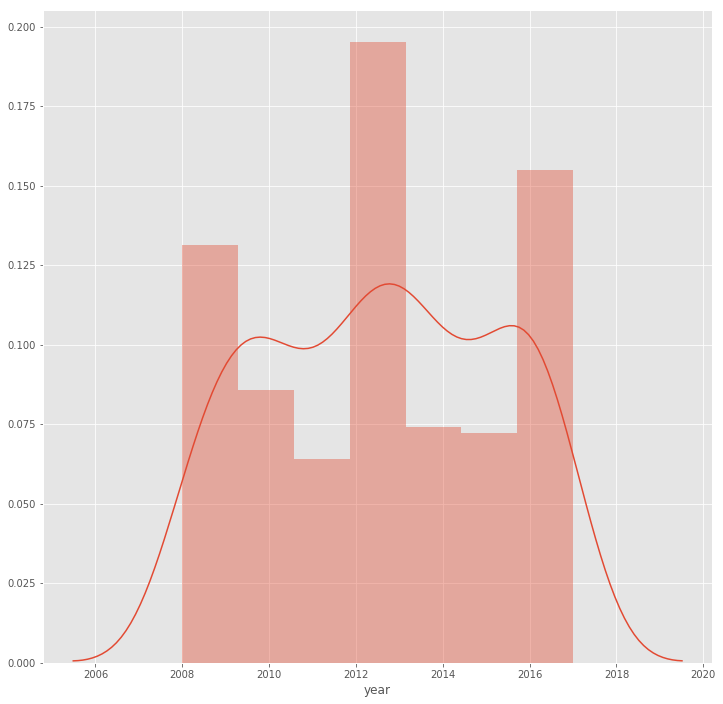

In [103]:
sns.distplot(date_rows['year'])

ValueError: List of boxplot statistics and `positions` values must have same the length

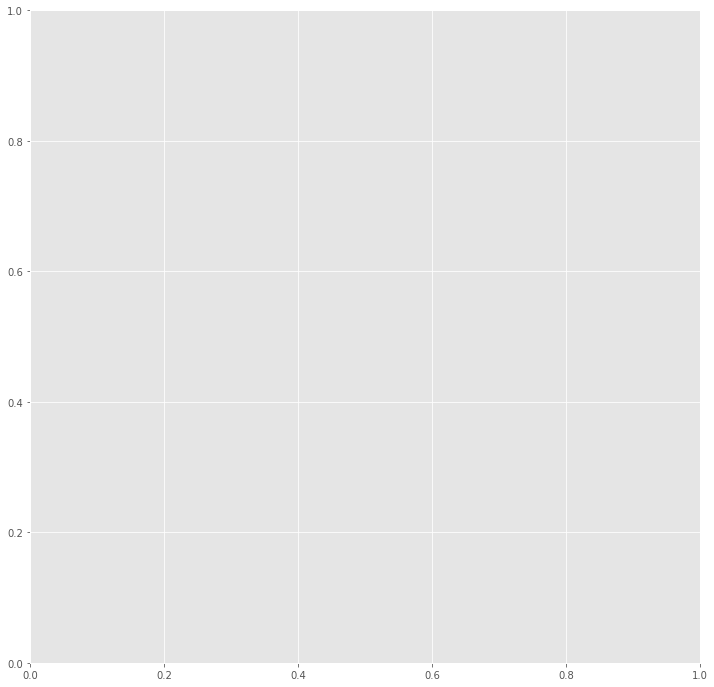

In [91]:
sns.boxplot(x='year', y='Num_Payments', data=date_rows)

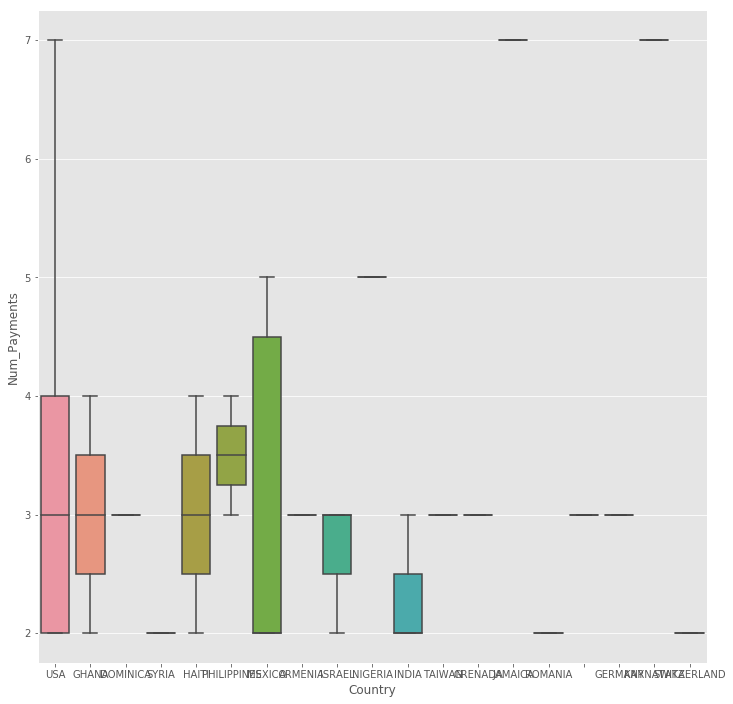

In [93]:
sns.boxplot(x='Country', y='Num_Payments', data=df[df.Num_Payments>1])

In [ ]:
myGrid=sns.FacetGrid(df,col='School',hue='School')
myGrid.map(sns.distplot,'Num_Payments')

ValueError: List of boxplot statistics and `positions` values must have same the length

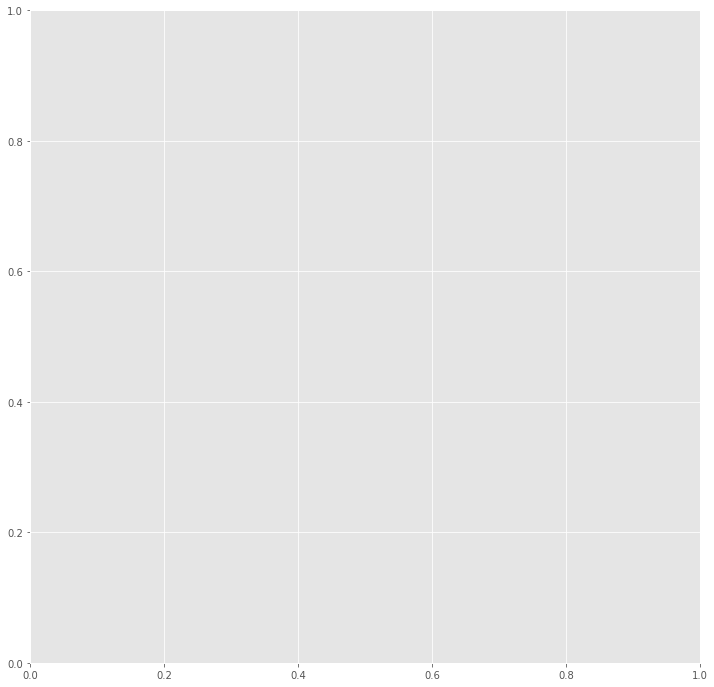

In [95]:
sns.boxplot(x='year', y='Num_Payments', data=date_rows)#[(df.State=="NY")])#& (df.Num_Payments>1)])

In [ ]:
df[df.Num_Payments>6]

In [ ]:
dir(new_df.date)
mal_rows